<a href="https://colab.research.google.com/github/AfsanehHabibi/movie-recommender/blob/main/movie_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from surprise import AlgoBase
from ast import literal_eval
import os
from IPython.display import display, HTML
from pandas.api.types import is_string_dtype
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
#from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn import linear_model#LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.preprocessing import KernelCenterer
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from surprise import PredictionImpossible
import seaborn as sns
import gplearn as gp
import numpy as np
from gplearn.genetic import *

# **Hybrid Movie Recommender System**
this notebook contains a hybrid system of collabrative filtering and content based.
the system trains on movies content information and user ratings of dataset, and becomes capable of predicting the rating of a user to movie

In [ ]:
dirname = '/kaggle/input/the-movies-dataset'

In [ ]:
def load_ratings_small_csv():
    filename = 'ratings_small.csv'
    ratings_small_df = pd.read_csv(os.path.join(dirname, filename), header=0,
                                   sep=",",
                                  dtype={"userId":'int64', "movieId":'int64',
                                         "rating":'float32','timestamp':'int64'})
    count_row = ratings_small_df.shape[0]
    count_col = ratings_small_df.shape[1]
    print("ratins small dataframe has shape ",count_row,count_col)
    print("ratings small dataframe has columns",ratings_small_df.dtypes)
    return ratings_small_df

In [ ]:
def load_links_small_csv():
    filename = 'links_small.csv'
    links_small_df = pd.read_csv(os.path.join(dirname, filename), header=0, sep=",",
                     dtype={'movieId':"int64",'imdbId':"int64", 'tmdbId':"Int64"})
    count_row = links_small_df.shape[0]
    count_col = links_small_df.shape[1]
    print("links small dataframe before droping NA vlaues has shape ",count_row,count_col)
    links_small_df = links_small_df.dropna()
    print(links_small_df.head())
    count_row = links_small_df.shape[0]
    count_col = links_small_df.shape[1]
    print("links small dataframe after droping NA vlaues has shape ",count_row,count_col)
    print("link small dataframe has columns",links_small_df.dtypes)
    return links_small_df

In [ ]:
def load_credits_csv():
    filename = 'credits.csv'
    credits_df = pd.read_csv(os.path.join(dirname, filename), header=0, sep=",",
                 dtype={'cast':'object','crew':'object', 'id':'int64'})
    count_row = credits_df.shape[0]
    count_col = credits_df.shape[1]
    print("credits dataframe has shape ",count_row,count_col)
    print("credits dataframe has columns",credits_df.dtypes)
    return credits_df

In [ ]:
def load_keywords_csv():
    filename = 'keywords.csv'
    keywords_df = pd.read_csv(os.path.join(dirname, filename), header=0, sep=",",
                 dtype={'id':'int64','keywords':'object'})
    count_row = keywords_df.shape[0]
    count_col = keywords_df.shape[1]
    print("keywords dataframe has shape ",count_row,count_col)
    print("keywords dataframe has columns",keywords_df.dtypes)
    return keywords_df

In [ ]:
def load_movies_metadata_csv():
    filename = 'movies_metadata.csv'
    movies_metadata_df = pd.read_csv(os.path.join(dirname, filename), header=0, sep=",",
                                    skiprows=[19731,29504,35588],
                                     parse_dates=['release_date'],
                                     dtype={'adult':'bool',
                                            'belongs_to_collection':'object',
                                            'budget':'int64',
                                            'genres':'object',
                                            'id':'int64',
                                            'imdb_id':'string',
                                            'original_language':'string',
                                            'original_title':'string',
                                            'overview':'string',
                                            'popularity':'float64',
                                            'poster_path':'object',
                                            'production_companies':'object',
                                            'production_countries':'object',
                                            #'release_date':'string',
                                            'revenue':'float64',
                                            'runtime':'float64',
                                            'spoken_languages':'object',
                                            'status':'string',
                                            'tagline':'string',
                                            'title':'string',
                                            'video':'object',
                                            'vote_average':'float64',
                                            'homepage':'string',
                                            'poster_path':'string',
                                            'vote_count':'float64'})
    #print(movies_metadata_df.head())
    #is_error = pd.to_numeric(movies_metadata_df['id'], errors='coerce').isna()
    #print(movies_metadata_df[is_error])
    #print(movies_metadata_df.iloc[19730])
    count_row = movies_metadata_df.shape[0]  # Gives number of rows
    count_col = movies_metadata_df.shape[1]  # Gives number of columns
    print("movies_metadata_df dataframe has shape ",count_row,count_col)
    print("movies_metadata_df dataframe has columns",movies_metadata_df.dtypes)
    return movies_metadata_df

In [ ]:
def load_data_sets():
    credits_df = load_credits_csv()
    keywords_df = load_keywords_csv()
    movies_metadata_df = load_movies_metadata_csv()
    links_small_df = load_links_small_csv()
    print(links_small_df.head())
    print("start")
    ratings_small_df = load_ratings_small_csv()
    print(links_small_df.head())
    print("s2")
    return credits_df, keywords_df, movies_metadata_df, links_small_df, ratings_small_df

In [ ]:
def remove_duplicate_data(credits_df, keywords_df, movies_metadata_df, links_small_df, ratings_small_df):
    count_row = links_small_df.shape[0]
    count_col = links_small_df.shape[1]
    print("links small data frame before removing duplicate has shape ",count_row,count_col)
    credits_df.drop_duplicates(subset=['id'],inplace=True)
    count_row = credits_df.shape[0]
    count_col = credits_df.shape[1]
    print("credits data frame after removing duplicate has shape ",count_row,count_col)
    keywords_df.drop_duplicates(subset=['id'],inplace=True)
    count_row = keywords_df.shape[0]
    count_col = keywords_df.shape[1]
    print("keywords data frame after removing duplicate has shape ",count_row,count_col)
    movies_metadata_df.drop_duplicates(subset=['id'],inplace=True)
    count_row = movies_metadata_df.shape[0]
    count_col = movies_metadata_df.shape[1]
    print("movies metadata data frame after removing duplicate has shape ",count_row,count_col)
    print(links_small_df.head())
    links_small_df.drop_duplicates(subset=['movieId'],inplace=True)
    count_row = links_small_df.shape[0]
    count_col = links_small_df.shape[1]
    print("links small data frame after removing duplicate has shape ",count_row,count_col)
    return credits_df, keywords_df, movies_metadata_df, links_small_df, ratings_small_df

In [ ]:
def join_movies_data(credits_df, keywords_df, movies_metadata_df):
    movies_all_contentdata_df = pd.merge(keywords_df, credits_df, on='id', how='inner'
                                        ,validate='one_to_one')
    movies_all_contentdata_df = pd.merge(movies_all_contentdata_df, movies_metadata_df, on='id', how='inner'
                                        ,validate='one_to_one')
    count_row = movies_all_contentdata_df.shape[0]  # Gives number of rows
    count_col = movies_all_contentdata_df.shape[1]  # Gives number of columns
    print("movies all contentdata dataframe has shape ",count_row,count_col)
    return movies_all_contentdata_df

In [ ]:
def link_movies(small, movies_df,links_small_df):
    if small :
        print(movies_df.head())

        links_small_df.rename(columns={'tmdbId': 'id'}, inplace=True)
        print(links_small_df.head())
        movies_df = pd.merge(movies_df, links_small_df, on='id', how='inner'
                                        )
        count_row = movies_df.shape[0]
        count_col = movies_df.shape[1]
        print("movies small subset all contentdata dataframe has shape ",count_row,count_col)
    return movies_df


In [ ]:
def convert_dataset_dtype(movies_all_contentdata_df):
    for (col_name, col_data) in movies_all_contentdata_df.iteritems():
        if movies_all_contentdata_df[col_name].dtype == 'object':
            print(col_name)
            movies_all_contentdata_df[col_name] = movies_all_contentdata_df[col_name].apply(lambda i:
                                                          i if i != i else literal_eval(i))
    return movies_all_contentdata_df

In [ ]:
def load_content_data_reform():
    credits_df, keywords_df, movies_metadata_df, links_small_df, ratings_small_df = load_data_sets()

    credits_df, keywords_df, movies_metadata_df, links_small_df, ratings_small_df = remove_duplicate_data(credits_df, keywords_df, movies_metadata_df, links_small_df, ratings_small_df)

    movies_all_contentdata_df = join_movies_data(credits_df, keywords_df, movies_metadata_df)

    movies_all_contentdata_df = link_movies(small = True, movies_df = movies_all_contentdata_df,links_small_df = links_small_df)

    movies_all_contentdata_df = convert_dataset_dtype(movies_all_contentdata_df)

    assert movies_all_contentdata_df.duplicated(subset=['movieId']).any() == False

    movies_all_contentdata_df = movies_all_contentdata_df.sort_values(by=['movieId'])

    return ratings_small_df, movies_all_contentdata_df

In [ ]:
ratings_small_df, movies_all_contentdata_df = load_content_data_reform()

credits dataframe has shape  45476 3
credits dataframe has columns cast    object
crew    object
id       int64
dtype: object
keywords dataframe has shape  46419 2
keywords dataframe has columns id           int64
keywords    object
dtype: object
movies_metadata_df dataframe has shape  45463 24
movies_metadata_df dataframe has columns adult                              bool
belongs_to_collection            object
budget                            int64
genres                           object
homepage                         string
id                                int64
imdb_id                          string
original_language                string
original_title                   string
overview                         string
popularity                      float64
poster_path                      string
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                

In [ ]:
    '''
    this function get data frame containing movies information and list of columns,
    and convert this coulmns data to string.
    '''
    def columns_to_string(content,use_cols):
        if 'keywords' in use_cols:
            content['keywords'] = content['keywords'].apply(lambda i: i if i != i else [ x['name'] for j, x in enumerate(i) ])
            content['keywords'] = content['keywords'].apply(lambda i: i if i != i else ' '.join(i))

        if 'cast' in use_cols:
            content['cast'] = content['cast'].apply(lambda i: i if i != i else [ x['name'].replace(' ','/') +' '+ x['character'] for j, x in enumerate(i[:3]) ])
            content['cast'] = content['cast'].apply(lambda i: i if i != i else ' '.join(i))

        if 'Director' or 'Screenplay' in use_cols:
            content['crew'] = content['crew'].apply(lambda i: i if i != i else [ (x['name']).replace(' ','/') for j, x in enumerate(i) if x['job'] in use_cols])
            content['crew'] = content['crew'].apply(lambda i: i if i != i else ' '.join(i))

        if 'belongs_to_collection' in use_cols:
            content['belongs_to_collection'] = movies_all_contentdata_df['belongs_to_collection'].apply(lambda i: i if i != i else i['name'])

        if 'genres' in use_cols:
            content['genres'] = content['genres'].apply(lambda i: i if i != i else [ x['name'] for j, x in enumerate(i) ])
            content['genres'] = content['genres'].apply(lambda i: i if i != i else ' '.join(i))

        if 'production_companies' in use_cols:
            content['production_companies'] = content['production_companies'].apply(lambda i: i if i != i else [ x['name'] for j, x in enumerate(i) ])
            content['production_companies'] = content['production_companies'].apply(lambda i: i if i != i else ' '.join(i))

        if 'production_countries' in use_cols:
            content['production_countries'] = content['production_countries'].apply(lambda i: i if i != i else [ x['iso_3166_1'] for j, x in enumerate(i) ])
            content['production_countries'] = content['production_countries'].apply(lambda i: i if i != i else ' '.join(i))

        if 'spoken_languages' in use_cols:
            content['spoken_languages'] = content['spoken_languages'].apply(lambda i: i if i != i else [ x['iso_639_1'] for j, x in enumerate(i) ])
            content['spoken_languages'] = content['spoken_languages'].apply(lambda i: i if i != i else ' '.join(i))

        return content

In [ ]:
def build_corpus(use_cols=[]):
    content = movies_all_contentdata_df.copy()
    content.insert(column='corpus', value=' ', allow_duplicates=False, loc=0)
    content = columns_to_string(content, use_cols)
    content = merge_cols_to_corpus(content, use_cols)
    return content

In [ ]:
movies_all_contentdata_df.head()

,id,keywords,cast,crew,adult,belongs_to_collection,budget,genres,homepage,imdb_id,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId,imdbId
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,<NA>,Toy Story,False,7.7,5415.0,1,114709
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",<NA>,tt0113497,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2,113497
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",<NA>,tt0113228,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,3,113228
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",<NA>,tt0114885,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4,114885
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",<NA>,tt0113041,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5,113041


In [ ]:
'''
only columns that chosed as relevent parameters joins togather,
the output of this step is the corpus of relevent words.
'''
def merge_cols_to_corpus(content, use_cols):
    array = np.array(use_cols)
    cols = np.unique(np.where((array=='Director') | (array=='Screenplay'), 'crew', array)).tolist()
    for i in cols:
        content[i] = content[i].fillna(' ')
        content['corpus'] += content[i]
    return content

In [ ]:
movies_all_contentdata_df

,id,keywords,cast,crew,adult,belongs_to_collection,budget,genres,homepage,imdb_id,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId,imdbId
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,<NA>,Toy Story,False,7.7,5415.0,1,114709
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",<NA>,tt0113497,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2,113497
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",<NA>,tt0113228,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,3,113228
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",<NA>,tt0114885,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4,114885
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",<NA>,tt0113041,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5,113041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,159550,"[{'id': 6054, 'name': 'friendship'}, {'id': 20...","[{'cast_id': 1, 'character': 'Henry Cobb', 'cr...","[{'credit_id': '544475aac3a36819fb000578', 'de...",False,NaN,8000000,"[{'id': 18, 'name': 'Drama'}]",<NA>,tt0255313,...,85.0,[],Released,<NA>,The Last Brickmaker in America,False,7.0,1.0,161944,255313
9078,392572,"[{'id': 10540, 'name': 'bollywood'}]","[{'cast_id': 0, 'character': 'Rustom Pavri', '...","[{'credit_id': '5951baf692514129c4016600', 'de...",False,NaN,1000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 10749,...",<NA>,tt5165344,...,150.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Decorated Officer. Devoted Family Man. Defendi...,Rustom,False,7.3,25.0,162542,5165344
9079,402672,"[{'id': 10540, 'name': 'bollywood'}]","[{'cast_id': 0, 'character': 'Sarman', 'credit...","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",False,NaN,15050000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",<NA>,tt3859980,...,155.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,<NA>,Mohenjo Daro,False,6.7,26.0,162672,3859980
9080,315011,"[{'id': 1299, 'name': 'monster'}, {'id': 7671,...","[{'cast_id': 4, 'character': 'Rando Yaguchi : ...","[{'credit_id': '560892fa92514177550018b2', 'de...",False,NaN,15000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",<NA>,tt4262980,...,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,163056,4262980


In [ ]:
'''
we create two dictionaries for users and movies to map id to index of utility matrix
for each one,we also reverse this two dictionaries and build two other dictionaries
that map index to id
'''
def build_dictionaries():
    users_id = np.unique(ratings_small_df['userId'].to_numpy())
    content_movies_id = np.unique(movies_all_contentdata_df['movieId'].to_numpy())
    movies_id = np.intersect1d(np.unique(ratings_small_df['movieId'].to_numpy()),
              movies_all_contentdata_df['movieId'].to_numpy())
    movies_id.shape
    users_id_to_sorted_index_dict = {x: i for i,x in enumerate(users_id)}
    movies_id_to_content_sorted_index_dict = {x:i for i,x in enumerate(content_movies_id)}
    index_to_users_id_dict = dict((reversed(item) for item in users_id_to_sorted_index_dict.items()))
    index_to_movies_id_dict = dict((reversed(item) for item in movies_id_to_content_sorted_index_dict.items()))
    return (users_id_to_sorted_index_dict, index_to_users_id_dict, movies_id_to_content_sorted_index_dict, index_to_movies_id_dict)


In [ ]:
(users_id_to_sorted_index_dict, index_to_users_id_dict,
    movies_id_to_content_sorted_index_dict, index_to_movies_id_dict) = build_dictionaries()

In [ ]:
'''
from ratings data frame we build this matrix which
each element of this matrix (movie_id, user_id) shows rating of user to movie,
to find indices for user and movie we used dictionaries that we build earlie
'''
def build_movie_user_matrix(movie_id,rating,user_id):
    if movie_id in movies_id_to_content_sorted_index_dict:
        return (movies_id_to_content_sorted_index_dict[movie_id],users_id_to_sorted_index_dict[user_id],rating)

In [ ]:
def plot_density(predict, actual):
    avg = np.zeros(shape=(1,9))
    for i in np.linspace(1,5,9):
        arr_indices = np.where(actual == i)
        indices_matrix = np.full(actual.shape, False)
        j =0
        while j < len(arr_indices[0]):
            indices_matrix[arr_indices[0][j],arr_indices[1][j]] = True
            j+=1
        x = np.linspace(0, 10, len(arr_indices[0]))
        y = [predict[i[0],i[1]]  for i in np.transpose(arr_indices)]
        #plt.plot(x, y, 'o', color='black');
        #plt.title(i)
        #plt.show()
        chart1, ax1 = plt.subplots()
        sns.set_style('whitegrid')
        sns.kdeplot(y, bw=0.0025,ax=ax1).set_title("density for rating "+str(i))
        avg[0,int((i-1)/0.5)] = np.sum(predict, where=indices_matrix) / len(arr_indices[0])
    return avg


In [ ]:
def inverse_scale2(predict, actual):
    rand = random.randint(0,users_dim)
    print(rand)
    avg = np.zeros(shape=(1,9))
    for i in np.linspace(1,5,9):
        arr_indices = np.where(actual == i)
        indices_matrix = np.full(actual.shape, False)
        j =0
        num = 0
        while j < len(arr_indices[0]):
            if arr_indices[1][j] == rand :
                indices_matrix[arr_indices[0][j],arr_indices[1][j]] = True
                num+=1
            j+=1
        x = np.linspace(0, 10, len(arr_indices[0]))
        y = [predict[i[0],i[1]]  for i in np.transpose(arr_indices)]
        #plt.plot(x, y, 'o', color='black');
        #plt.title(i)
        #plt.show()
        #chart1, ax1 = plt.subplots()
        #sns.set_style('whitegrid')
        #sns.kdeplot(y, bw=0.0025,ax=ax1)
        print(num)
        avg[0,int((i-1)/0.5)] = np.sum(predict, where=indices_matrix) / num
    return avg


In [ ]:
def scale_element(i,passed):
    print(i.shape)
    difference_array = np.absolute(passed[0]-i)
    # find the index of minimum element from the array
    index = difference_array.argmin()
    return index*0.5 + 1

In [ ]:
def calculate_avg_per_user(predict, actual):
    avg = np.zeros(shape=(users_dim,9))
    for i in np.linspace(1,5,9):
        arr_indices = np.where(actual == i)
        for i in range(0,users_dim):
            indices_matrix = np.full(actual.shape, False)
            j =0
            num = 0
            while j < len(arr_indices[0]):
                #if
                indices_matrix[arr_indices[0][j],arr_indices[1][j]] = True
                j+=1
                num+=1
            avg[0,int((i-1)/0.5)] = np.sum(predict, where=indices_matrix) / num

In [ ]:
def inverse_transform_average(predict, actual):
    avg = np.zeros(shape=(1,9))
    for i in np.linspace(1,5,9):
        arr_indices = np.where(actual == i)
        indices_matrix = np.full(actual.shape, False)
        j =0
        while j < len(arr_indices[0]):
            indices_matrix[arr_indices[0][j],arr_indices[1][j]] = True
            j+=1
        x = np.linspace(0, 10, len(arr_indices[0]))
        y = [predict[i[0],i[1]]  for i in np.transpose(arr_indices)]
        avg[0,int((i-1)/0.5)] = np.sum(predict, where=indices_matrix) / len(arr_indices[0])
    avg = avg.ravel()
    scale_pre = np.empty(shape=predict.shape)
    for x in range(0, predict.shape[0]):
        for y in range(0, predict.shape[1]):
            scale_pre[x,y] = (np.absolute(avg-predict[x,y])).argmin()*0.5 + 1
    return  scale_pre



In [ ]:
def rmse(actual, prediction):
    return np.sqrt(np.nanmean((actual - prediction) ** 2))

## show similar movies
by calculating cosine similarity betwean tdfIdf and itself, we can measure the similarity between the movies

In [ ]:
#movie_to_movie_similarity =  cosine_similarity(tfidf_matrix,tfidf_matrix)

In [ ]:
def show_similar_movies():
    movie_num = random.randint(0,movies_dim)
    print("most similar movies to ",movies_all_contentdata_df.iloc[movie_num]['title'])
    similar_movies = np.flip(np.argsort(movie_to_movie_similarity[movie_num]))[0:20]
    assert movies_id_to_content_sorted_index_dict[movies_all_contentdata_df.iloc[movie_num]['movieId']] == movie_num
    for i in similar_movies:
        print(movies_all_contentdata_df.iloc[i]['title'])

In [ ]:
#show_similar_movies()

In [ ]:
def unknown_id(uid):
    return int(uid[len('UKN__'):])

In [ ]:
def inverse_transform_genetic(predict, actual, rlist):
    x = []
    y = []
    for (i,j,r) in rlist:
        if i in movies_id_to_content_sorted_index_dict:
            x.append(predict[movies_id_to_content_sorted_index_dict[i]][users_id_to_sorted_index_dict[j]])
            y.append(r)
    x = np.array(x)
    y = np.array(y)
    #print(x)
    #print(y)
    est = gp.genetic.SymbolicRegressor(random_state=4)
    x = x.reshape(-1, 1)
    #y = y.reshape(-1, 1)
    est.fit(x, y)
    #print(est._program)
    return  est.predict(predict.reshape(-1,1)).reshape(predict.shape)



In [ ]:
class HybridAlgorithm(AlgoBase):

    def __init__(self, sim_options={}, bsl_options={},coef=0.5,blend_option='coef'):
        self.sim_options = sim_options
        self.bsl_options = bsl_options
        self.coef = coef
        self.blend_option = blend_option

    def fit(self, trainset):
        self.trainset = trainset
        print(self.coef)
        self.collab_algo = KNNWithMeans(sim_options=self.sim_options)
        self.collab_algo.fit(trainset)
        print(self.bsl_options)
        self.content_algo = MFMovieContentBased(sim_options=self.bsl_options)
        self.content_algo.fit(trainset)
        if self.blend_option != 'coef':
            self.blend_results()
        return self

    def blend_results(self):
        testset = self.trainset.build_testset()
        collab_predictions = self.collab_algo.test(testset)
        content_predictions = self.content_algo.test(testset)

        collab_list = []
        content_list = []
        y_list = []
        for value in collab_predictions:
            collab_list.append(value.est)
            y_list.append(value.r_ui)
        for value in content_predictions:
            content_list.append(value.est)
        x = np.column_stack((np.array(collab_list),np.array(content_list)))
        #print(x.shape)
        #y = np.array(y_list)
        print(y.shape)
        if self.blend_option == 'linear_reg':
            self.hybrid = linear_model.LinearRegression().fit(x,y)
        elif self.blend_option == 'poly_reg':
            self.poly = preprocessing.PolynomialFeatures(degree=2)
            X_ = self.poly.fit_transform(x)
            self.hybrid = linear_model.LinearRegression().fit(X_,y)
        elif self.blend_option == 'genetic':
            self.hybrid = gp.genetic.SymbolicRegressor(random_state=4).fit(x,y)

    def estimate(self, u, i):
        try:
            collab_est = self.collab_algo.estimate(u,i)[0]
        except:
            collab_est = np.nan
        try:
            content_est = self.content_algo.estimate(u,i)
        except:
            content_est = np.nan
        if np.isnan(collab_est) and np.isnan(content_est):
            raise PredictionImpossible('User and/or item is unknown.')
        elif np.isnan(collab_est):
            return content_est
        elif np.isnan(content_est):
            return collab_est
        else:
            if self.blend_option == 'coef':
                return (1-self.coef)*content_est + self.coef*collab_est
            elif self.blend_option == 'linear_reg' or self.blend_option == 'genetic':
                #print(collab_est,content_est)
                return self.hybrid.predict(np.array([[collab_est,content_est]]))
            elif self.blend_option == 'poly_reg':
                P_ = self.poly.fit_transform(np.array([[collab_est,content_est]]))
                return self.hybrid.predict(P_)
        '''if not (self.trainset.knows_user(u) and  ( self.trainset.knows_item(i) or
                       (unknown_id(i) in movies_id_to_content_sorted_index_dict))):
            raise PredictionImpossible('User and/or item is unknown.')
        user_id = self.trainset.to_raw_uid(u)
        user_id = users_id_to_sorted_index_dict[user_id]
        if not self.trainset.knows_item(i):
            movie_id = movies_id_to_content_sorted_index_dict[unknown_id(i)]
            return self.content_algo.estimate(u, i)
        movie_id = self.trainset.to_raw_iid(i)
        if movie_id not in movies_id_to_content_sorted_index_dict:
            return self.collab_algo.estimate(u,i)
        movie_id = movies_id_to_content_sorted_index_dict[movie_id]
        #P_ = self.poly.fit_transform(np.array([[self.collab_algo.estimate(u,i)[0],self.content_algo.estimate(u,i)]]))
        return (1-self.coef)*self.content_algo.estimate(u,i)  + self.coef*(self.collab_algo.estimate(u,i)[0])
    #self.hybrid.predict(P_)'''
    #self.hybrid.predict(np.array([[self.collab_algo.estimate(u,i)[0],self.content_algo.estimate(u,i)]]))
    #(1-self.coef)*self.content_algo.estimate(u,i)  + self.coef*(self.collab_algo.estimate(u,i)[0])

In [ ]:
class MFMovieContentBased(AlgoBase):

    def __init__(self, sim_options={},bsl_options = {} ):
        self.sim_options = { 'min_df':0.0001,'max_df':1,
                                    'inverse_transform':'standard','stop_words':None}
        self.sim_options.update(sim_options)
        self.bsl_options = bsl_options

    def fit(self, trainset):
        self.trainset = trainset
        print(self.sim_options)
        contentdata_df = build_corpus(self.sim_options['corpus_content'])
        min_df = self.sim_options['min_df']
        max_df = self.sim_options['max_df']
        stop_words = self.sim_options['stop_words']
        #print(min_df,max_df,stop_words)
        '''
        we need to show movies with vectors of the same size and exteract features,
        one of the ways to that its to use tdfIdf, in result matrix
        first dimension is the movies that their content is available in
        content data frame sorted by their movieId and second dimension is
        the features exteracted from corpus
        '''
        tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=min_df,max_df=max_df, stop_words=stop_words)
        #display(contentdata_df['corpus'])
        tfidf_matrix = tfidf.fit_transform(contentdata_df['corpus'])
        users_dim = ratings_small_df['userId'].nunique()
        movies_dim = tfidf_matrix.shape[0]
        input_ratings = np.zeros(shape=(movies_dim,users_dim))
        input_ratings[:] = np.nan
        self.rawid = self.trainset.ir.items()
        self.rlist = []
        for (iiid, l) in self.rawid:
            riid = self.trainset.to_raw_iid(iiid)
            for (iuid,r) in l:
                ruid = self.trainset.to_raw_uid(iuid)
                self.rlist.append((riid,ruid,r))
        '''result = [build_movie_user_matrix(row[0], row[1], row[2]) for row in
          zip(ratings_small_df['movieId'],ratings_small_df['rating'],ratings_small_df['userId'])]
        #print(result)
        result = list(filter(None, result))
        for (i,j,r) in result:
            input_ratings[i][j] = r'''
        for (i,j,r) in self.rlist:
            if i in movies_id_to_content_sorted_index_dict:
                input_ratings[movies_id_to_content_sorted_index_dict[i]][users_id_to_sorted_index_dict[j]] = r
        #result = [x for x in result if x != x]
        #print(len(result))
        #result = result[~np.isnan(result)]
        #result = np.array(result, dtype='int,int,float')
        #print(result)
        #input_ratings[result[:,0].astype(int), result[:,1].astype(int)] = result[:,2]
        #print(input_ratings)
        scaler = preprocessing.StandardScaler(with_std=False).fit(input_ratings)
        movie_user_matrix = scaler.transform(input_ratings)
        movie_user_matrix = np.nan_to_num(movie_user_matrix)
        movie_user_matrix_transpose = np.transpose(movie_user_matrix)
        tfidf_matrix_transpose = np.transpose(tfidf_matrix)
        users_profile = linear_kernel(tfidf_matrix_transpose,movie_user_matrix_transpose)
        users_profile_transpose = np.transpose(users_profile)
        predictions = cosine_similarity(users_profile_transpose,tfidf_matrix)
        predictions_transpose = np.transpose(predictions)

        plot_density(predictions_transpose,input_ratings)

        if self.sim_options['inverse_transform'] == 'standard':
            self.content_output = scaler.inverse_transform(predictions_transpose)
        elif self.sim_options['inverse_transform'] == 'genetic':
            self.content_output = inverse_transform_genetic(predictions_transpose,
                                                        input_ratings, self.rlist)
        elif self.sim_options['inverse_transform'] == 'average':
            self.content_output = inverse_transform_average(predictions_transpose,
                                                        input_ratings)
        return self

    def get_output_matrix(self):
        return self.content_output

    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and  ( self.trainset.knows_item(i) or
                       (unknown_id(i) in movies_id_to_content_sorted_index_dict))):
            raise PredictionImpossible('User and/or item is unknown.')
        user_id = self.trainset.to_raw_uid(u)
        user_id = users_id_to_sorted_index_dict[user_id]
        if not self.trainset.knows_item(i):
            movie_id = movies_id_to_content_sorted_index_dict[unknown_id(i)]
        else:
            movie_id = self.trainset.to_raw_iid(i)
        if movie_id not in movies_id_to_content_sorted_index_dict:
            raise PredictionImpossible('User and/or item is unknown.')
        movie_id = movies_id_to_content_sorted_index_dict[movie_id]
        return self.content_output[movie_id][user_id]

In [ ]:
def test_hybrid():
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_small_df[["userId", "movieId", "rating"]], reader)
    train, test = train_test_split(data, test_size=0.2,random_state=4)
    sim_options = {
            "name": "cosine",
            "user_based": False,
    }
    content_options = {
        'min_df': 0.0001,
        'max_df': 0.6,
        'corpus_content': ['genres']
    }
    algo = HybridAlgorithm(sim_options=sim_options, bsl_options=content_options,
                          coef = 0.6, blend_option = 'coef')
    algo.fit(train)
    predictions = algo.test(test)
    #for (a ,b ,d) in predictions:
    #    print(a)
    return predictions#accuracy.rmse(predictions)

In [ ]:
def test_content():
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_small_df[["userId", "movieId", "rating"]], reader)
    train, test = train_test_split(data, test_size=0.2,random_state=4)
    sim_options = {
        'min_df': 0.01,
        'max_df': 0.5,
        'stop_words':None,
        'corpus_content': ['genres','keywords'],
        'inverse_transform':'standard'
    }
    algo = MFMovieContentBased(sim_options=sim_options)
    algo.fit(train)
    predictions = algo.test(test)
    return predictions

In [ ]:
def MFMovieContentBased_tune_parameters():

    first_best = 0.01
    min_df_range_l1 = np.linspace(0.01,0.04,4)
    max_df_range_l1 = np.linspace(0.5,0.3,3)
    columns = ['Director','belongs_to_collection','cast','Screenplay',
                    'original_language', 'overview','spoken_languages','title',
                'production_companies', 'production_countries', 'tagline']
    first_best = 'genres'
    second_best = 'keywords'
    corpus_content = []
    corpus_content.append(['genres','keywords'])
    for c in columns:
        corpus_content.append(['genres','keywords',c])
    print(corpus_content)
    param_grid = {
                    'sim_options':{
                            'min_df':min_df_range_l1,
                            'max_df':max_df_range_l1,
                            'stop_words':[None,'english'],
                            'corpus_content':corpus_content,
                            'inverse_transform':['standard']
                        }}
    grid_search = GridSearchCV(MFMovieContentBased, param_grid, measures=['RMSE'],cv=5)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_small_df[["userId", "movieId", "rating"]], reader)
    grid_search.fit(data)

    return grid_search

{'min_df': 0.01, 'max_df': 0.5, 'inverse_transform': 'standard', 'stop_words': None, 'corpus_content': ['genres', 'keywords']}


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.0025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.0025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.0025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated 

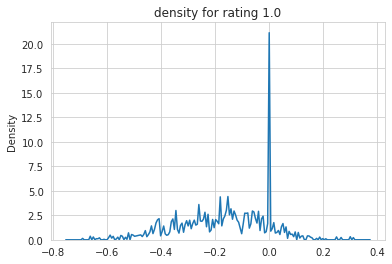

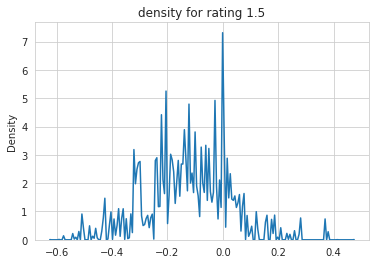

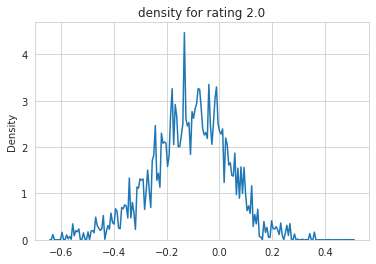

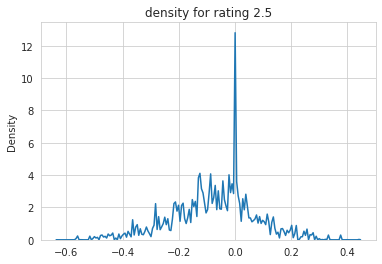

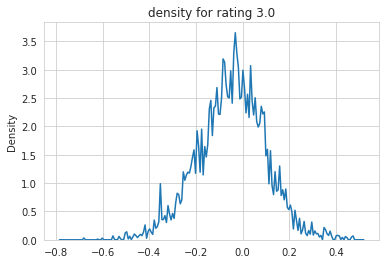

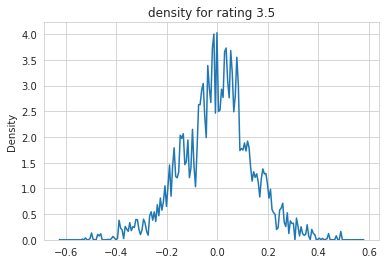

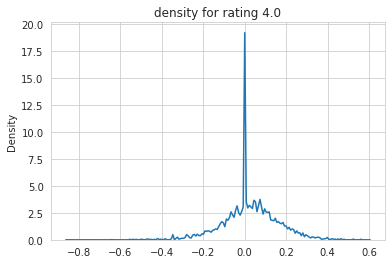

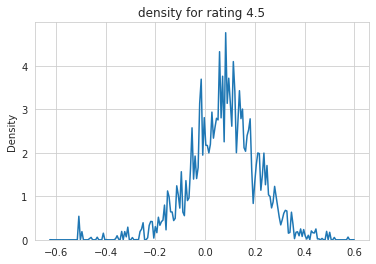

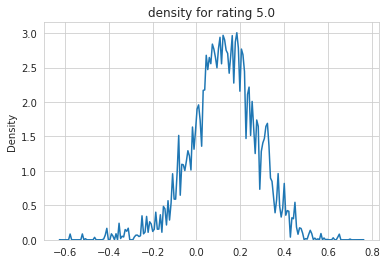

In [ ]:
predictions = test_content()

In [ ]:
#accuracy.rmse(predictions)

In [ ]:
#result = MFMovieContentBased_tune_parameters()

In [ ]:
result.best_score['rmse']

0.954027120576915

In [ ]:
result.best_params['rmse']

{'sim_options': {'min_df': 0.01,
  'max_df': 0.5,
  'stop_words': None,
  'corpus_content': ['genres', 'keywords'],
  'inverse_transform': 'standard'}}

In [ ]:
result.best_index['rmse']

246

In [ ]:
result.cv_results

{'split0_test_rmse': array([0.97982959, 0.96412803, 0.96475413, 0.96455874, 0.96365141,
        0.96644083, 0.9703636 , 0.96540327, 0.964963  , 0.96180122,
        0.96356645, 0.96680286, 0.96492558, 0.97982959, 0.96413397,
        0.9652002 , 0.96474528, 0.96364771, 0.96644083, 0.97011926,
        0.9657673 , 0.96677783, 0.96170163, 0.96338076, 0.96536647,
        0.96485047, 0.96885386, 0.96412803, 0.96475413, 0.96455874,
        0.96365141, 0.96644083, 0.97035159, 0.96540327, 0.964963  ,
        0.96180122, 0.96356645, 0.96680286, 0.96492558, 0.96885386,
        0.96413397, 0.9652002 , 0.96474528, 0.96364771, 0.96644083,
        0.97011926, 0.9657673 , 0.96677783, 0.96170163, 0.96338076,
        0.96536647, 0.96485047, 0.96885386, 0.96412803, 0.96475413,
        0.96455874, 0.96365141, 0.96644083, 0.97038675, 0.96540327,
        0.964963  , 0.96180122, 0.96356645, 0.96680286, 0.96492558,
        0.96885386, 0.96413397, 0.9652002 , 0.96474528, 0.96364771,
        0.96644083, 0.970119

In [ ]:
#test1_full_data_set()

In [ ]:
#test2_split_data_set()

In [ ]:
def tune_parameters_with_grid_search():
    #param_grid = {'sim_options':{'name': ['cosine'],
    #        'user_based': [False,True]},
    #             'hybrid_options':[0,0.2,0.4,0.6,0.8,1]}
    param_grid = {'sim_options':{'name': ['cosine'],
            'user_based': [False]},
                 'hybrid_options':[0.44,0.48,0.52,0.56,0.6,0.64,0.68,0.72,0.76]}
    #print(param_grid['hybrid_options']['coef'])
    grid_search = GridSearchCV(HybridAlgorithm, param_grid, measures=['RMSE'],cv=5)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_small_df[["userId", "movieId", "rating"]], reader)
    grid_search.fit(data)

    return grid_search

In [ ]:
#result = tune_parameters_with_grid_search()

In [ ]:
u_m = [[2,5,3,5],[1,4,1,3],[5,3,5,3],[4,1,3,2]]
u_m = np.transpose(u_m)
s = preprocessing.StandardScaler(with_std=False).fit(u_m)
p_m = s.transform(u_m)

In [ ]:
p_m

array([[-1.75, -1.25,  1.  ,  1.5 ],
       [ 1.25,  1.75, -1.  , -1.5 ],
       [-0.75, -1.25,  1.  ,  0.5 ],
       [ 1.25,  0.75, -1.  , -0.5 ]])

In [ ]:
text = ['PG animation adventure comedy toy talking toy pixar disney',
        'Rage mystery thriller memorylose wifelose unexpectedending murder new market',
        'PG animation adventure comedy memory escape family pixar disney',
        'Rage mystery thriller delusion  wifelose unexpectedending murder paramount pictures'
       ]
tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df = 2,stop_words=None)
        #display(contentdata_df['corpus'])
tfidf_matrix = tfidf.fit_transform(text)

In [ ]:
p_t = np.transpose(p_m)
tfidf_matrix_transpose = np.transpose(tfidf_matrix)
users_profile = linear_kernel(tfidf_matrix_transpose,p_t)

In [ ]:
np.transpose(users_profile)

array([[-1.02062073, -1.02062073, -1.02062073, -1.02062073,  1.02062073,
         1.02062073, -1.02062073, -1.02062073,  1.02062073,  1.02062073,
         1.02062073,  1.02062073],
       [-1.02062073, -1.02062073, -1.02062073, -1.02062073,  1.02062073,
         1.02062073, -1.02062073, -1.02062073,  1.02062073,  1.02062073,
         1.02062073,  1.02062073],
       [ 0.81649658,  0.81649658,  0.81649658,  0.81649658, -0.81649658,
        -0.81649658,  0.81649658,  0.81649658, -0.81649658, -0.81649658,
        -0.81649658, -0.81649658],
       [ 0.81649658,  0.81649658,  0.81649658,  0.81649658, -0.81649658,
        -0.81649658,  0.81649658,  0.81649658, -0.81649658, -0.81649658,
        -0.81649658, -0.81649658]])

In [ ]:
users_profile_transpose = np.transpose(users_profile)
predictions = cosine_similarity(users_profile_transpose,tfidf_matrix)
predictions_transpose = np.transpose(predictions)
content_output = s.inverse_transform(predictions_transpose)

In [ ]:
content_output

array([[3.04289322, 1.54289322, 4.70710678, 3.20710678],
       [4.45710678, 2.95710678, 3.29289322, 1.79289322],
       [3.04289322, 1.54289322, 4.70710678, 3.20710678],
       [4.45710678, 2.95710678, 3.29289322, 1.79289322]])

In [ ]:
tfidf.get_feature_names()

['adventure',
 'animation',
 'comedy',
 'disney',
 'murder',
 'mystery',
 'pg',
 'pixar',
 'rage',
 'thriller',
 'unexpectedending',
 'wifelose']

In [ ]:
tfidf_matrix.toarray()

array([[0.40824829, 0.40824829, 0.40824829, 0.40824829, 0.        ,
        0.        , 0.40824829, 0.40824829, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.40824829,
        0.40824829, 0.        , 0.        , 0.40824829, 0.40824829,
        0.40824829, 0.40824829],
       [0.40824829, 0.40824829, 0.40824829, 0.40824829, 0.        ,
        0.        , 0.40824829, 0.40824829, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.40824829,
        0.40824829, 0.        , 0.        , 0.40824829, 0.40824829,
        0.40824829, 0.40824829]])